In [1]:
import pandas as pd
from multiprocessing import Pool
import datetime
import json
import concurrent
import networkx as nx
import random


In [ ]:

number_of_lines_per_patch = 1000
count = 0
def process_book(reviews: list[dict]):
    result = []
    for review in reviews:
        user_id = review['user_id']
        book_id = review['book_id']
        rating = review['rating']
        date_added = review['date_added']
        n_votes = review['n_votes']
        n_comments = review['n_comments']    
        try:
            book_id = int(book_id)
            rating = int(rating)
            n_votes = int(n_votes)
            n_comments = int(n_comments)
            date_added = int(date_added[-4:])
            result.append( {
                'book_id':book_id,
                'user_id':user_id,
                'rating': rating,
                'date_added': date_added,
                'n_votes': n_votes,
                'n_comments': n_comments
            }
        )
        except Exception:
            continue
    return result
        
futures = []
with open('dataset/goodreads_reviews_dedup.json',"r") as jsonfile:
    with concurrent.futures.ThreadPoolExecutor(1000) as executor:
        while True:
            try:
                lines = [json.loads(next(jsonfile)) for _ in range(number_of_lines_per_patch)]
            except Exception:
                break
            if len(lines) == 0:
                break
            
            futures.append(executor.submit(process_book, lines))
            count += 1
            if(count%100 == 0):
                print(count)
        print(count)

all_edges = [v for f in futures for v in f.result()]

interactions = pd.DataFrame(all_edges) 
interactions.to_csv('dataset/reviews.csv')

In [127]:
interactions = pd.read_csv("dataset/reviews.csv")
interactions

,Unnamed: 0,book_id,user_id,rating,date_added,n_votes,n_comments
0,0,24375664,8842281e1d1347389f2ab93d60773d4d,5,2017,16,0
1,1,18245960,8842281e1d1347389f2ab93d60773d4d,5,2017,28,1
2,2,6392944,8842281e1d1347389f2ab93d60773d4d,3,2017,6,0
3,3,22078596,8842281e1d1347389f2ab93d60773d4d,4,2017,22,4
4,4,6644782,8842281e1d1347389f2ab93d60773d4d,4,2017,8,0
...,...,...,...,...,...,...,...
15738995,15738995,13147091,04938d7a33a3fb6b4224fd4e4ee6d119,4,2012,0,0
15738996,15738996,17333223,6fd7b24d8ed1cdb89b9e52cd6ca9c0e2,4,2013,0,0
15738997,15738997,136878,2c468b4a7c7b836f4dc60a875a536a74,2,2007,0,0
15738998,15738998,10614,2c468b4a7c7b836f4dc60a875a536a74,5,2007,0,0


In [ ]:
interactions.loc[(interactions['rating'] == 0)]

In [66]:
interactions = interactions.loc[(interactions['rating'] > 3) & (interactions['date_added'] >= 2007) & (2017 > interactions['date_added'])]
# interactions = interactions.sample(1000000)
interactions

,Unnamed: 0,book_id,user_id,rating,date_added,n_votes,n_comments
0,0,24375664,8842281e1d1347389f2ab93d60773d4d,5,2017,16,0
1,1,18245960,8842281e1d1347389f2ab93d60773d4d,5,2017,28,1
3,3,22078596,8842281e1d1347389f2ab93d60773d4d,4,2017,22,4
4,4,6644782,8842281e1d1347389f2ab93d60773d4d,4,2017,8,0
6,6,9460786,8842281e1d1347389f2ab93d60773d4d,4,2017,13,3
...,...,...,...,...,...,...,...
15738994,15738994,7937843,04938d7a33a3fb6b4224fd4e4ee6d119,5,2012,0,0
15738995,15738995,13147091,04938d7a33a3fb6b4224fd4e4ee6d119,4,2012,0,0
15738996,15738996,17333223,6fd7b24d8ed1cdb89b9e52cd6ca9c0e2,4,2013,0,0
15738998,15738998,10614,2c468b4a7c7b836f4dc60a875a536a74,5,2007,0,0


In [67]:
book_groups = interactions.groupby('book_id').user_id.count()
print(len(book_groups))
filtered_book_ids = book_groups[book_groups>2].index.tolist()
print(len(filtered_book_ids))
interactions = interactions.loc[interactions['book_id'].isin(filtered_book_ids)]
interactions

1589064
515342


,Unnamed: 0,book_id,user_id,rating,date_added,n_votes,n_comments
0,0,24375664,8842281e1d1347389f2ab93d60773d4d,5,2017,16,0
1,1,18245960,8842281e1d1347389f2ab93d60773d4d,5,2017,28,1
3,3,22078596,8842281e1d1347389f2ab93d60773d4d,4,2017,22,4
7,7,29983426,8842281e1d1347389f2ab93d60773d4d,5,2017,26,6
8,8,29893493,8842281e1d1347389f2ab93d60773d4d,5,2016,29,8
...,...,...,...,...,...,...,...
15738994,15738994,7937843,04938d7a33a3fb6b4224fd4e4ee6d119,5,2012,0,0
15738995,15738995,13147091,04938d7a33a3fb6b4224fd4e4ee6d119,4,2012,0,0
15738996,15738996,17333223,6fd7b24d8ed1cdb89b9e52cd6ca9c0e2,4,2013,0,0
15738998,15738998,10614,2c468b4a7c7b836f4dc60a875a536a74,5,2007,0,0


### Choose Active Users
choose users that have been active in the last year, so that our analysis become more reliable particularly to evaluate our recommendation system.
###### Todo: adjust the final random sampling (20000)

In [68]:
import random

latest_interactions = interactions.loc[interactions['date_added'] == 2016]
active_users = sorted(set(latest_interactions['user_id']))
print(len(active_users))
random.seed(4423)
active_users = random.sample(active_users, 5000)

interactions = interactions.loc[interactions['user_id'].isin(active_users)]
interactions

,Unnamed: 0,book_id,user_id,rating,date_added,n_votes,n_comments
3868,3868,36144466,f88032f4ad97b46654fe59ce3387cf5d,4,2017,2,0
3869,3869,36220216,f88032f4ad97b46654fe59ce3387cf5d,5,2017,1,1
3870,3870,35722431,f88032f4ad97b46654fe59ce3387cf5d,5,2017,1,0
3871,3871,35796943,f88032f4ad97b46654fe59ce3387cf5d,5,2017,3,0
3873,3873,34933505,f88032f4ad97b46654fe59ce3387cf5d,5,2017,2,0
...,...,...,...,...,...,...,...
15738259,15738259,18739537,c870c0587538fe88c77b4f5dd9c34087,5,2016,0,0
15738261,15738261,12935765,c870c0587538fe88c77b4f5dd9c34087,5,2015,0,0
15738262,15738262,259764,c870c0587538fe88c77b4f5dd9c34087,4,2014,1,0
15738263,15738263,563797,c870c0587538fe88c77b4f5dd9c34087,5,2012,0,1


In [69]:
dates = interactions.groupby('date_added')
dates.count()

,Unnamed: 0,book_id,user_id,rating,n_votes,n_comments
date_added,,,,,,
2007,897,897,897,897,897,897
2008,3182,3182,3182,3182,3182,3182
2009,4856,4856,4856,4856,4856,4856
2010,7226,7226,7226,7226,7226,7226
2011,13041,13041,13041,13041,13041,13041
2012,20548,20548,20548,20548,20548,20548
2013,28109,28109,28109,28109,28109,28109
2014,34713,34713,34713,34713,34713,34713
2015,40966,40966,40966,40966,40966,40966


### Remove Books Reviewed by few users
To create a stringly connected network we prevent crreation of completely isolated partitions in users network ignorng books that are liked by less than 3 users

In [70]:
book_groups = interactions.groupby('book_id').user_id.count()
print(len(book_groups))
filtered_book_ids = book_groups[book_groups>2].index.tolist()
print(len(filtered_book_ids))
interactions = interactions.loc[interactions['book_id'].isin(filtered_book_ids)]
interactions

119990
16230


,Unnamed: 0,book_id,user_id,rating,date_added,n_votes,n_comments
3888,3888,33115353,f88032f4ad97b46654fe59ce3387cf5d,4,2017,2,0
3904,3904,28439219,f88032f4ad97b46654fe59ce3387cf5d,5,2016,1,0
3922,3922,25845800,f88032f4ad97b46654fe59ce3387cf5d,4,2016,1,0
3952,3952,24513660,f88032f4ad97b46654fe59ce3387cf5d,5,2015,2,0
3963,3963,21957948,f88032f4ad97b46654fe59ce3387cf5d,5,2014,2,0
...,...,...,...,...,...,...,...
15734164,15734164,30247358,6e43b1392017f5adb9cc7f06b2d12b08,4,2016,0,0
15734934,15734934,24727094,76b51c89152d50ec282bc16686bc2ef2,5,2016,1,0
15736478,15736478,91582,b8b204ef214a54d77e03ac5afec51100,4,2017,0,0
15736482,15736482,1885,b8b204ef214a54d77e03ac5afec51100,5,2016,0,0


In [71]:
grouped = interactions.groupby('book_id')
print(grouped.count())

          Unnamed: 0  user_id  rating  date_added  n_votes  n_comments
book_id                                                               
1                 60       60      60          60       60          60
2                 58       58      58          58       58          58
3                145      145     145         145      145         145
5                 79       79      79          79       79          79
6                 79       79      79          79       79          79
...              ...      ...     ...         ...      ...         ...
36172234           3        3       3           3        3           3
36182685           3        3       3           3        3           3
36232086           4        4       4           4        4           4
36274157           3        3       3           3        3           3
36328685           3        3       3           3        3           3

[16230 rows x 6 columns]


## Network Construction
Create the graph in which users constitute the nodes. Two users that have rated the same book with 4 or 5 stars are connected through a link.

In [72]:
# %%script false --no-raise-error

import concurrent.futures
import networkx as nx
import time

G = nx.Graph()

def process_group(group_name, group_df):
    print(f"{group_name} started")
    t = time.time()
    edges = []
    ll = group_df['user_id'].tolist()
    for i in range(len(ll) - 1):
        for j in range(i + 1, len(ll)):
            edges.append((ll[i], ll[j]))
    
    elapsed_time = time.time() - t
    print(f"{group_name} with {len(group_df)} took {elapsed_time:.3f} seconds")
    return edges

with concurrent.futures.ThreadPoolExecutor(1000) as executor:
    # Submit each group to the executor
    futures = [executor.submit(process_group, group_name, group_df) for group_name, group_df in grouped]

# Wait for all tasks to complete
concurrent.futures.wait(futures)

all_edges = set(v for f in futures for v in f.result())
print(len(all_edges))
G.add_edges_from(all_edges)


1 started
1 with 60 took 0.001 seconds
2 started
2 with 58 took 0.000 seconds
3 started
3 with 145 took 0.002 seconds
5 started
5 with 79 took 0.000 seconds
6 started
6 with 79 took 0.001 seconds
11 started
11 with 39 took 0.000 seconds
13 started
13 with 6 took 0.000 seconds
21 started
21 with 18 took 0.000 seconds
24 started
24 with 4 took 0.000 seconds
25 started
25 with 5 took 0.001 seconds
27 started
27 with 5 took 0.000 seconds
28 started
28 with 5 took 0.000 seconds
29 started
29 with 4 took 0.000 seconds
33 started
33 with 24 took 0.000 seconds
34 started
34 with 26 took 0.000 seconds
50 started
50 with 6 took 0.000 seconds
67 started
67 with 3 took 0.000 seconds
93 started
93 with 9 took 0.000 seconds
98 started
98 with 3 took 0.000 seconds
122 started
122 with 4 took 0.000 seconds
151 started
151 with 6 took 0.000 seconds
152 started
152 with 9 took 0.000 seconds
264 started
264 with 3 took 0.000 seconds
275 started
275 with 6 took 0.000 seconds
295 started
295 with 8 took 0.

In [80]:
print(G.number_of_edges())
print(G.number_of_nodes())
print((G.number_of_edges()*2)/G.number_of_nodes())
print(G.number_of_nodes() * (G.number_of_nodes()-1) /2)

627333
4513
278.0115222690007
10181328.0


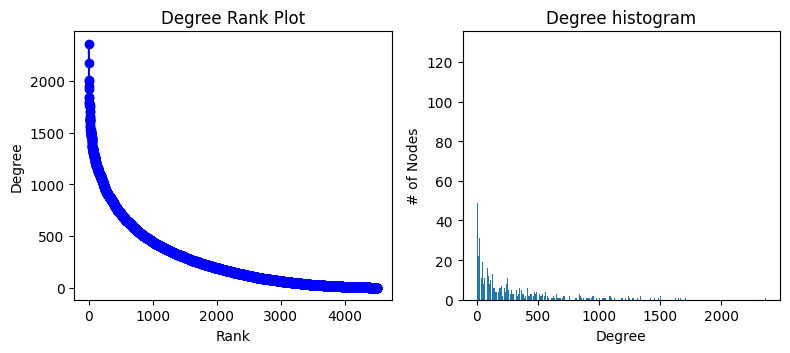

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# G = nx.gnp_random_graph(100, 0.02, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

# ax0 = fig.add_subplot(axgrid[0:3, :])
# Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(Gcc, seed=10396953)
# nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
# nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
# ax0.set_title("Connected components of G")
# ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

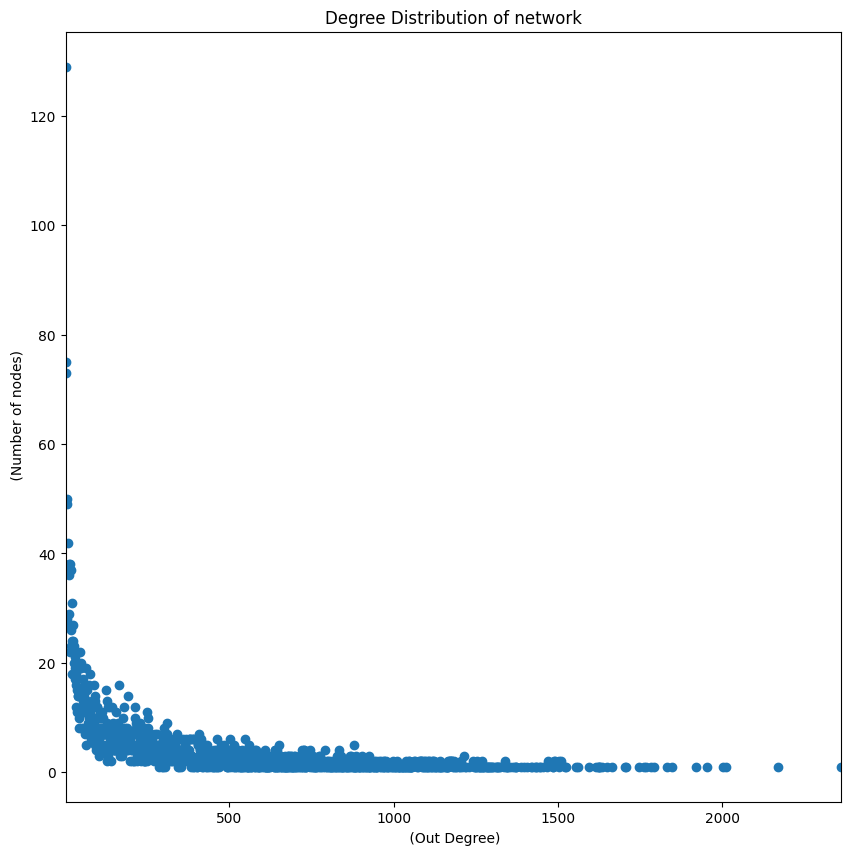

In [14]:
import numpy as np
import matplotlib.pyplot as plt


out_degrees = dict(G.degree()) # dictionary node:degree
# filtering nodes outdegree values with outdegree > 0
pos_out_degree_vals = list(filter(lambda val: val > 0, out_degrees.values()))
# getting unique and sorted outdegree values
uq_pos_out_degree_vals = sorted(set(pos_out_degree_vals))
# counting frequency of each outdegree values
out_hist = [pos_out_degree_vals.count(x) for x in uq_pos_out_degree_vals]


x = np.asarray(uq_pos_out_degree_vals, dtype = float)
y = np.asarray(out_hist, dtype = float)

plt.figure(figsize=(10,10))
plt.xlim(min(x), max(x))
plt.xlabel(' (Out Degree)')
plt.ylabel(' (Number of nodes)')
plt.title('Degree Distribution of network')
out_degree_dist = plt.plot(x, y, 'o')

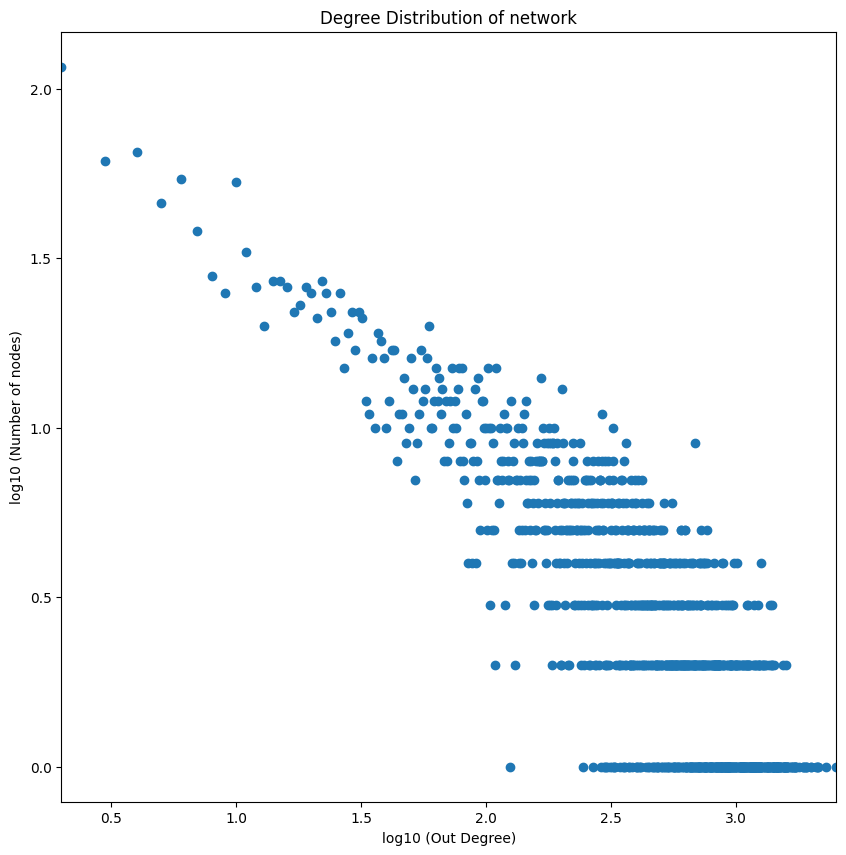

In [74]:
## degree Distribution
import numpy as np
out_degrees = dict(G.degree()) # dictionary node:degree
# filtering nodes outdegree values with outdegree > 0
pos_out_degree_vals = list(filter(lambda val: val > 0, out_degrees.values()))
# getting unique and sorted outdegree values
uq_pos_out_degree_vals = sorted(set(pos_out_degree_vals))
# counting frequency of each outdegree values
out_hist = [pos_out_degree_vals.count(x) for x in uq_pos_out_degree_vals]


x = np.asarray(uq_pos_out_degree_vals, dtype = float)
y = np.asarray(out_hist, dtype = float)

logx = np.log10(x)
logy = np.log10(y)

plt.figure(figsize=(10,10))
plt.xlim(min(logx), max(logx))
plt.xlabel('log10 (Out Degree)')
plt.ylabel('log10 (Number of nodes)')
plt.title('Degree Distribution of network')
out_degree_dist = plt.plot(logx, logy, 'o')

In [75]:
nx.write_edgelist(G, 'dataset/users.edgelist.gz')

In [76]:
G = nx.read_edgelist('dataset/users.edgelist.gz')

In [77]:
G_2017 = nx.read_edgelist('dataset/users_2017.edgelist.gz')

## Components

In [17]:
connected_components = list(nx.connected_components(G))
print(len(connected_components))

1


### louvain_communities

#### find the best seed for louvain_communities

In [18]:
from networkx.algorithms.community import louvain_communities, modularity

scores = {}
for i in range(0, 10000):
    seed  = random.randint(0,99999999)
    c = louvain_communities(G, seed=seed, threshold=0)
    x = modularity(G, c, weight = None)
    scores[seed] = x
    print('seed:', seed, 'modularity:', x, '#:', len(c))

seed: 73932771 modularity: 0.19277077117987002 #: 6
seed: 86687110 modularity: 0.196637607501956 #: 6
seed: 88901617 modularity: 0.1936291716355315 #: 7
seed: 61554097 modularity: 0.19619987756517163 #: 6
seed: 13557136 modularity: 0.19602696198938455 #: 8
seed: 53727411 modularity: 0.19949690062608189 #: 6
seed: 13187583 modularity: 0.19629362533428427 #: 8
seed: 10098375 modularity: 0.19708848200225332 #: 8
seed: 69865574 modularity: 0.1950478056263334 #: 7
seed: 58283815 modularity: 0.1966128192730717 #: 7
seed: 90593712 modularity: 0.19227561027642173 #: 6
seed: 67171126 modularity: 0.19562591500346943 #: 6
seed: 24527369 modularity: 0.19694087366365046 #: 8
seed: 42552538 modularity: 0.19151983589723293 #: 7
seed: 25775178 modularity: 0.1982291433954533 #: 7
seed: 28415746 modularity: 0.1943918219853457 #: 8
seed: 7044339 modularity: 0.19687860947888472 #: 7
seed: 82459085 modularity: 0.1996709539550456 #: 6
seed: 78686684 modularity: 0.19411436429360795 #: 7
seed: 36748585 modula

KeyboardInterrupt: 

In [19]:
best_seed = sorted(scores.items(), key=lambda item: item[1], reverse=True)[0][0]
# best_seed = 28196672
best_seed

45681059

In [20]:
communities = louvain_communities(G, seed=best_seed, threshold=0)
len(communities)

7

In [22]:
communities = [c for c in communities if len(c)>10]

In [23]:
for c in communities:
    print(len(c))

1088
283
2031
74
282
111
644


In [24]:
modularity(G, communities, weight = None)

0.19979015687898743

In [108]:
for comm_id, comm_nodes in enumerate(communities):
    for node in comm_nodes:
        G.nodes[node]["community"] = comm_id

### girvan_newman

In [52]:
from networkx.algorithms.community import girvan_newman, modularity
import itertools
import datetime

prev_modularity = -1


def should_continue(c):
    global prev_modularity
    new_modularity = modularity(G, list(c), weight = None)
    print('comparing', prev_modularity, new_modularity)
    if new_modularity > prev_modularity + 0.000001:
        prev_modularity = new_modularity
        return True
    else:
        return False

gn_community = girvan_newman(G)
# len(communities)
# for x in communities:
#     print(type(x))
# tuple(len(c) for c in next(communities))
# next(communities)

limited = itertools.takewhile(should_continue, gn_community)
final_communities = []
count = 0
print('starting...')
for comm in limited: 
    final_communities = list(comm)
    count += 1
    print(count, datetime.datetime.now(), len(final_communities))

print('final', modularity(G, final_communities, weight = None))
len(final_communities)

starting...
comparing -1 2.6743581205292972e-06
1 2024-02-28 23:14:56.375350 2
comparing 2.6743581205292972e-06 5.348701936612078e-06
2 2024-02-28 23:47:11.063567 3
comparing 5.348701936612078e-06 8.022999262840974e-06
3 2024-02-29 00:51:33.127715 4
comparing 8.022999262840974e-06 8.022970653673112e-06
final 8.022999262840974e-06


4

In [88]:
modularity(G, final_communities, weight = None)

8.022999262840974e-06

### Plot Communities

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 3: Create a color map for the communities
colors = []

# Create a mapping of node to color
node_color = {}

for i, comm in enumerate(communities):
    for node in comm:
        node_color[node] = i
# for color, node in zip(colors, G.nodes()):
#     node_color[node] = color

# # Step 4: Draw the graph with community colors
# plt.figure(figsize=(10, 7))
# nx.draw_networkx(G, node_color=[node_color[node] for node in G.nodes()], with_labels=False, node_size=100, cmap=plt.cm.jet)
# plt.show()

In [26]:
node_colors = [node_color[node] for node in G.nodes()]
set(node_colors)

{0, 1, 2, 3, 4, 5, 6}

In [27]:
import math

# pos = nx.spring_layout(G, seed=42)  # Increase node separation
pos = {}
angle = math.pi * 2 / len(communities)

for comm_id, comm_nodes in enumerate(communities):
    for node in comm_nodes:
        pos[node] = (math.cos(comm_id * angle) + random.random()/2.0 - 0.25, math.sin(comm_id * angle) + random.random()/2.0 - 0.25)
nx.set_edge_attributes(G, name="concentrate", values=True)  # Enable edge concentration

In [28]:
edge_colors = []
num_intera_cluster, num_within_cluster = 0, 0
for edge in list(G.edges()):
    i = [i for i, comm in enumerate(communities) if edge[0] in comm]
    j = [i for i, comm in enumerate(communities) if edge[1] in comm]
    if i==j:
        num_within_cluster += 1
    else:
        num_intera_cluster += 1
    edge_colors.append('#000000' if i==j else '#ff0000')
print(num_intera_cluster, num_within_cluster)

335401 291932


In [ ]:
# pos = {}
# for comm_id, comm_nodes in enumerate(communities):
#     for node in comm_nodes:
#         pos[node] = (comm_id + random.random()/2.0 - 0.25, random.random())
# nx.set_edge_attributes(G, name="concentrate", values=True)  # Enable edge concentration

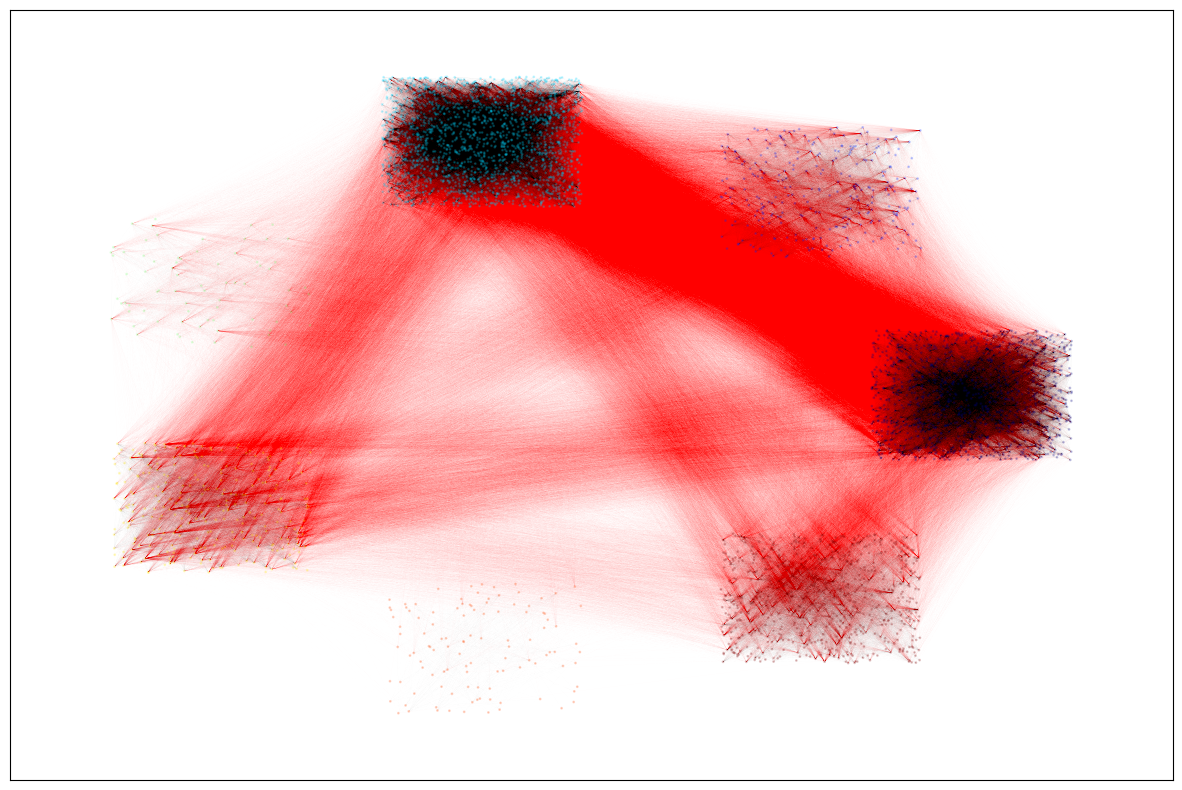

In [29]:

plt.figure(figsize=(15, 10))
nx.draw_networkx(
    G,
    pos=pos,
    nodelist=node_color.keys(),
    node_color=list(node_color.values()),
    with_labels=False,
    node_size=1,
    cmap=plt.cm.jet,
    font_size=8,
    font_color="white",
    width = 0.006,
    alpha = 0.2,
    edge_color=edge_colors
)
plt.show()

### Modularity

In [12]:
nx.community.modularity(G, communities, weight=None)

0.18152493035405937

the number of edges within groups exceeds the expected number. however, it is less than 0.3, so it does not mean significant community structure

### Diameter of the Network

In [ ]:
nx.shortest_path_length(G, source=list(G.nodes())[1000])

In [30]:
from  concurrent.futures import ThreadPoolExecutor, as_completed
import networkx as nx
from tqdm import tqdm

def compute_shortest_path(node):
    sps = nx.shortest_path_length(G, source=node)
    del sps[node]
    # print(node, 'done.')
    return (node, sps)

# pbar = tqdm(total=G.number_of_nodes())  # Init pbar

with ThreadPoolExecutor() as executor:
    # Submit each group to the executor
    futures = executor.map(compute_shortest_path, G.nodes())
    print('Jobs created.')
    results = list(tqdm(futures, total=G.number_of_nodes()))

print('here2')
shortest_paths = dict(r for r in results)
print('here3')
print(len(shortest_paths))

Jobs created.


100%|██████████| 4513/4513 [01:26<00:00, 51.90it/s]  

here2
here3
4513


Network Diameter:

In [31]:
diameter = 0
sum = 0
count = 0
for targets in shortest_paths.values():
    for length in targets.values():
        sum += length
        count += 1
        if length > diameter:
            diameter = length
print('average path lenght:', sum/count)
print('Diameter:', diameter)

average path lenght: 2.1636649953719203
Diameter: 5


In [ ]:
# p = dict(nx.shortest_path_length(G))
# p

In [ ]:
# diameter = nx.diameter(G)

### Clustering Coefficient

In [32]:
clustering = nx.clustering(G)
clustering

{'817236d48622c758e3687545d669d719': 0.3957292328753728,
 'ae43ce1a379ba902818c77c4e7e67814': 0.8193643754619364,
 '64e3e01af33ec6f0e0d22a929ab5fc9b': 0.34401897974338547,
 '9d52b131ff19781e37886ef3a1f2e6c3': 0.5218604025943475,
 '44b69fa10ee8a7489a48404d9f3e65c6': 0.5033384694401644,
 'ef402515b12f104651650bb11de7017a': 0.4729064039408867,
 '7f767b7772f3219a52de3662a13d23e4': 0.46206232681996473,
 'a30e675f7e1c04def5028c2a05f8f5c6': 0.4407418950127458,
 'cafff7931729983a3c4f3e29f1bcf963': 0.4681628282913107,
 '93df98fb4e33408eb21687a53319b492': 0.3810548130271114,
 'df21c6d0c76a0dff306ff1519c086c3c': 0.3160234851507724,
 '52af14d7d4b49ff086b0200254549579': 0.4696599412711945,
 'e80506edaaccab3edafaef0859d97eaf': 0.38641790854180236,
 '85b17a156be01701bbc4a474c1cd3837': 0.3837656954221371,
 '01dc81d9475d0019380f5e8cc66b4849': 0.4463615903975994,
 'd61da14b6914764a28cb40f88c622155': 0.3077024511324853,
 'fb8361859a66b752bf3ff6997a9ef062': 0.295057048127836,
 'b20521628f4eaa10570c73ea3ce

In [33]:
sum = 0
count = 0
for cc in clustering.values():
    sum += cc
    count += 1
print('average Clustering Coefficient:', sum/count)

average Clustering Coefficient: 0.6357256167062852


### Power Law

In [107]:
G.degree()

DegreeView({'10545055a446a513b56df60013976283': 1075, '1b195ea4db9c35ddce192a92de0dac1a': 1202, '78e3e18447a4adba95f7d20760d74d5f': 1082, '813957808d9bfe72bbc653ceb012a821': 282, '3bfec68bc1176ca9a81c2fbd69cafedb': 1072, 'cf2d20d9904a3b93fe8e32763483153f': 1309, 'e021b024b020b226471d33612bcc7f74': 312, 'efe474053a6016351885ebd3a038982d': 365, '75f4a47456099ade341023540e135eab': 264, '637e14c1407eac8e17fb51cfb6109bc3': 38, '771ff98572cd99ab4a6cf3ff81989615': 1353, 'e7ebf9fd8e9dabdb63f592488db38287': 753, 'dca22ada5bbe0aa926614eff644315d8': 856, '1cd55882a518421226bd495e7aa34e2a': 26, '49c9fbda27c2694b9ce1203e490499ff': 1855, 'de5cb7006ec99cdb1e1db1d411855966': 885, '60f9a8618cb784de18ea38901374c58b': 1792, '498a67ded36448a8972cfb0a6b4cc7a4': 250, '87f18aceb6eb551b1e5f72b1a67c13ac': 393, '469a125c5c74ecb5c2d9223a20bdb0f6': 1178, '0ee18750485fb85da47e334a6bfac655': 1230, 'cc50e6814eca19d5fd87dbeb910dfbdd': 481, '5110ad384f9fa4d1a2f557750676d777': 837, '1370ed340c7f4c5ff94a126691c9234e': 6

In [34]:
max_degree = max(list(dict(G.degree()).values()))
max_degree


2360

In [35]:
P_K = [0] * (max_degree+1)
for degree in list(dict(G.degree()).values()):
    P_K[degree] += 1 / G.number_of_nodes()
P_K

[0,
 0,
 0.028584090405495154,
 0.016618657212497234,
 0.016175493020163977,
 0.011079104808331493,
 0.010857522712164863,
 0.006204298692665635,
 0.008198537558165304,
 0.008198537558165304,
 0.009306448038998454,
 0.007976955461998675,
 0.008420119654331934,
 0.006425880788832265,
 0.004874806115665856,
 0.008420119654331934,
 0.0059827165964990055,
 0.005761134500332376,
 0.008198537558165304,
 0.005096388211832486,
 0.005317970307999116,
 0.003988477730999336,
 0.006869044981165525,
 0.0059827165964990055,
 0.005317970307999116,
 0.005096388211832486,
 0.003988477730999336,
 0.004431641923332596,
 0.005096388211832486,
 0.004210059827165966,
 0.0037668956348327065,
 0.004653224019499226,
 0.003988477730999336,
 0.004210059827165966,
 0.0035453135386660766,
 0.002658985153999557,
 0.002437403057832927,
 0.004874806115665856,
 0.0033237314424994467,
 0.002437403057832927,
 0.003102149346332817,
 0.003102149346332817,
 0.0022158209616662972,
 0.0033237314424994467,
 0.0017726567693330

C:\Users\rezaab\AppData\Local\Temp\ipykernel_1792\2009026083.py:21: RuntimeWarning: divide by zero encountered in log10
  mylogy = np.log10(P_K)


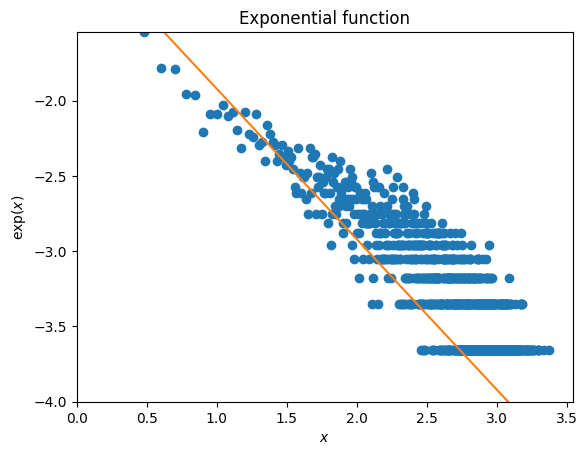

In [39]:
from math import log10
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, max_degree, 1000)
y = 0.12 * np.power(x, -1)

logx = np.log10(x)
logy = np.log10(y)

x2 = np.linspace(1, max_degree, 1000)
y2 = np.power(x, -2.5)

logx2 = np.log10(x2)
logy2 = np.log10(y2)


myx = np.linspace(1, max_degree, max_degree+1)

mylogx = np.log10(myx)
mylogy = np.log10(P_K)



plt.figure()
plt.plot(mylogx, mylogy, 'o')
plt.plot(logx, logy)
# plt.plot(logx2, logy2)
plt.xlabel("$x$")
plt.ylabel(r"$\exp(x)$")
plt.ylim(-4, max(mylogy))
plt.xlim(0)
plt.title("Exponential function")

plt.show()


Community
link prediction -> Recomendation

## Link Analysis

### Link Importance

#### HITS

In [40]:
(hubs,authorities) = nx.hits(G)

In [41]:
dict(sorted(hubs.items(), key=lambda item: item[1], reverse=True))

{'818a07d4b1a085d65a3851c9f68f148d': 0.001328756322389972,
 'bf2abe9a707f9581f8d32196958b6e05': 0.0012565593347469892,
 '4bd30b70ee73e1caf2cb0753e4b6504f': 0.001244130112196623,
 'cfe4738a5d926fc158d4fcb1287fe2c5': 0.0012293676164307678,
 'fc42cbb17f863f27ab7b8b231ef6e49a': 0.0012228367958134357,
 '2a0bca8d74bf6811e6c44df3f8ea0761': 0.0011971187217868758,
 '890fe00be33e1e5dc34a076343cfa15a': 0.0011879794449936483,
 'fa56c37387610a09380020f3a57d4629': 0.0011855032627274067,
 'cf8c1773ea4ff67cf2eca21761fd8345': 0.0011602841253297502,
 '69d6de82682308ae18acf638799094f5': 0.001153295526526259,
 'dceb4807abd7b25483354deaf817abe2': 0.0011492920521197134,
 '31af83257723e6cd61e4b09371ea9cf1': 0.001141722885951111,
 '307a9162351905aa4a88488ccc1bef37': 0.0011296976592635576,
 '1f07a083b9765d480e5fc06a63e6f129': 0.0011221679280052842,
 '9b807c0a39521f5c3ab0a3bc0e5f8851': 0.0011204588339191093,
 '8ec35dc892073f19e6583879f7206342': 0.0011148925537950655,
 'bded0233fcc6f1bdd59726f24c7f3688': 0.00111

In [42]:
dict(sorted(authorities.items(), key=lambda item: item[1], reverse=True))

{'818a07d4b1a085d65a3851c9f68f148d': 0.0013287563223899745,
 'bf2abe9a707f9581f8d32196958b6e05': 0.001256559334746988,
 '4bd30b70ee73e1caf2cb0753e4b6504f': 0.0012441301121966226,
 'cfe4738a5d926fc158d4fcb1287fe2c5': 0.001229367616430769,
 'fc42cbb17f863f27ab7b8b231ef6e49a': 0.0012228367958134342,
 '2a0bca8d74bf6811e6c44df3f8ea0761': 0.001197118721786874,
 '890fe00be33e1e5dc34a076343cfa15a': 0.0011879794449936453,
 'fa56c37387610a09380020f3a57d4629': 0.0011855032627274076,
 'cf8c1773ea4ff67cf2eca21761fd8345': 0.0011602841253297502,
 '69d6de82682308ae18acf638799094f5': 0.0011532955265262583,
 'dceb4807abd7b25483354deaf817abe2': 0.0011492920521197127,
 '31af83257723e6cd61e4b09371ea9cf1': 0.0011417228859511126,
 '307a9162351905aa4a88488ccc1bef37': 0.0011296976592635574,
 '1f07a083b9765d480e5fc06a63e6f129': 0.0011221679280052858,
 '9b807c0a39521f5c3ab0a3bc0e5f8851': 0.0011204588339191108,
 '8ec35dc892073f19e6583879f7206342': 0.0011148925537950679,
 'bded0233fcc6f1bdd59726f24c7f3688': 0.0011

#### Page Rank

In [43]:
pr = nx.pagerank(G)

In [44]:
dict(sorted(pr.items(), key=lambda item: item[1], reverse=True))

{'818a07d4b1a085d65a3851c9f68f148d': 0.0017953714729810298,
 'fc42cbb17f863f27ab7b8b231ef6e49a': 0.001710705940296152,
 '2a0bca8d74bf6811e6c44df3f8ea0761': 0.0014958863898261747,
 'bf2abe9a707f9581f8d32196958b6e05': 0.001408100255523234,
 'cfe4738a5d926fc158d4fcb1287fe2c5': 0.0013828929212075097,
 '31af83257723e6cd61e4b09371ea9cf1': 0.001351930478014139,
 '16bcc03cb29d0950f52a897ceaf8eb6e': 0.0013457673578387258,
 '7d310f25dd8e24af00e7ef6857c19a7b': 0.0013205384785736224,
 '4bd30b70ee73e1caf2cb0753e4b6504f': 0.0013105418027592574,
 '69d6de82682308ae18acf638799094f5': 0.0012754810503393717,
 'dceb4807abd7b25483354deaf817abe2': 0.0012672390671236724,
 '890fe00be33e1e5dc34a076343cfa15a': 0.001265526818220685,
 'bded0233fcc6f1bdd59726f24c7f3688': 0.0012388495553795527,
 'fa56c37387610a09380020f3a57d4629': 0.001199953746492966,
 '04bbadd525a062622b18b7d42edd8619': 0.0011915866585822542,
 'cf8c1773ea4ff67cf2eca21761fd8345': 0.0011768762858449288,
 '00b5b129cc3cfa6511418cce1cec54ab': 0.001172

In [45]:
G.degree(['818a07d4b1a085d65a3851c9f68f148d', '7ddb7cd66031a983e696cd0627d80a21'])

DegreeView({'818a07d4b1a085d65a3851c9f68f148d': 2360})

In [203]:
# !!pip install pybind11
!! python -m pip install graph-walker==1.0.6

['Collecting graph-walker==1.0.6',
 '  Using cached graph-walker-1.0.6.tar.gz (6.5 kB)',
 '  Preparing metadata (setup.py): started',
 "  Preparing metadata (setup.py): finished with status 'done'",
 'Requirement already satisfied: networkx in c:\\users\\rezaab\\appdata\\local\\programs\\python\\python312\\lib\\site-packages (from graph-walker==1.0.6) (3.2.1)',
 'Requirement already satisfied: numpy in c:\\users\\rezaab\\appdata\\local\\programs\\python\\python312\\lib\\site-packages (from graph-walker==1.0.6) (1.26.4)',
 'Requirement already satisfied: scipy in c:\\users\\rezaab\\appdata\\local\\programs\\python\\python312\\lib\\site-packages (from graph-walker==1.0.6) (1.12.0)',
 'Requirement already satisfied: pybind11 in c:\\users\\rezaab\\appdata\\local\\programs\\python\\python312\\lib\\site-packages (from graph-walker==1.0.6) (2.11.1)',
 'Requirement already satisfied: scikit-learn in c:\\users\\rezaab\\appdata\\local\\programs\\python\\python312\\lib\\site-packages (from graph-

In [173]:
import walker

X = walker.random_walks(G, n_walks=50, walk_len=25, start_nodes=[0, 1, 2])

ModuleNotFoundError: No module named 'walker'

### Link Prediction

In [103]:
def compute_accuracy(preds, n = 10000):
    count = 0
    c = 0
    for pred in preds[:n]:
        c+=1
        if G_2017.has_edge(pred[0], pred[1]):
            count += 1
    print(count, c)
    return count

def genrator_to_list(iterator):
    count = 0
    ret = []
    for val in iterator:
        count+=1
        if count%10000==0:
            print(count/9553000)

        ret.append(val)
    return ret

In [81]:
preds = nx.jaccard_coefficient(G)
jaccard_preds = sorted(genrator_to_list(preds), reverse=True)
compute_accuracy(jaccard_preds)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [118]:
preds = nx.adamic_adar_index(G)
adamic_adar_preds = sorted(genrator_to_list(preds), reverse=True, key=lambda item: item[2])
compute_accuracy(adamic_adar_preds)

1191 10000


1191

In [120]:
preds2 = nx.preferential_attachment(G)
pa_preds = sorted(genrator_to_list(preds2), reverse=True, key=lambda item: item[2])
compute_accuracy(pa_preds)

1047 10000


1047

In [124]:
preds = nx.cn_soundarajan_hopcroft(G)
cn_preds = sorted(genrator_to_list(preds), reverse=True)
compute_accuracy(cn_preds)

1385 10000


1385

In [110]:
simrank = nx.simrank_similarity(G)

In [114]:
sr_preds = []

for src, values in simrank.items():
    for target, value in values.items():
        sr_preds.append((src, target, value))

sr_preds = sorted(sr_preds, key=lambda item: item[2], reverse=True)

compute_accuracy(sr_preds)

654 10000


654